In [1]:
pip install EoN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 13.3 MB/s 
  Created wheel for EoN: filename=EoN-1.1-py3-none-any.whl size=120820 sha256=163a7c3eeb34afc94ccec94a506c4f46986261ce37380a9ef18d5bdb5d4b27f0
  Stored in directory: /root/.cache/pip/wheels/0b/c0/a4/d6001fd809cb84c027ada5c2ab3b6d1cb2e97fec3f9978eae7
Successfully built EoN


In [2]:
pip install pyprobs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import EoN
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import numpy as np
from pyprobs import Probability as pr

In [28]:
## creates connected graph with node attributes either 'isolated' or 'general'
N = 10000
# ISO_PROP varied for research
ISO_PROP = 0.1

G = nx.fast_gnp_random_graph(N, 10./(N-1))

# creates dictionary where each node has attribute 'isolated' = 0/1
node_attributes = {}
for node in G.nodes():
  p = pr.prob(ISO_PROP)
  if p == True : node_attributes[node] = {1}
  else: node_attributes[node] = {0}

nx.set_node_attributes(G, values=node_attributes, name='isolation_binary')

In [29]:
## checks size of isolated cluster (~ ISO_PROP * N)
i = 0
for node in G.nodes():
  if node_attributes[node] == {1}: i += 1
print(i)

997


In [30]:
## defines SIR simulation model, including parameters, contact rate function, 
## and both spontaneous and induced transition digraphs

# parameters (PROP_VAX varied for research)
PROP_VAX = 0.9
VAX_EFF = 0.97
TRANSMISSION_RATE = 0.9
# mean infectious period = 8 days
GAMMA = 1/8
# US birth rate = .012/year * 1 year/365 days
MU = .012/365
# US death rate = .008/year * 1 year/365 days
ETA = .008/365

# general population: x% vaccinated at birth w/ efficacy = 97%
    # born to 'R' if vaccinated and effective, 'S' otherwise
# isolated are unvaccinated, all go to 'S'
def rate_function_iso(G, node):
  if node == {1}:
    return 1.0
  elif node == {0}:
    return (1-PROP_VAX) + PROP_VAX*(1-VAX_EFF)

def rate_function_gen(G, node):
  if node == {0}:
    return PROP_VAX * VAX_EFF
  elif node == {1}:
    return 0.0

# spontaneous transition digraph, specified by SIR model & parameter values
H = nx.DiGraph()
H.add_edge('B', 'S', rate=MU*rate_function_iso(G=G, node=G.nodes[node]['isolation_binary']))
H.add_edge('B', 'R', rate=MU*rate_function_gen(G=G, node=G.nodes[node]['isolation_binary']))
H.add_edge('I', 'R', rate=GAMMA)
H.add_edge('S', 'D', rate=ETA)
H.add_edge('I', 'D', rate=ETA)
H.add_edge('R', 'D', rate=ETA)
# keep birth "reservoir" full
H.add_edge('D', 'B', rate = 1)

# contact rates vary within vs. between clusters to simulate isolation in network
def contact_rate(G, source, target):
# beta = transmission rate * contact rate
# contact rate (defined here) = 
                              # 2.0 for both isolated
                              # 0.1 for isolated <--> general
                              # 1.0 for both general
  if source == {1} and target == {1}:
    return 2.0
  elif source != target:
    return 0.1
  elif source == {0} and target == {0}:
    return 1.0

# induced transition digraph (i.e. S --> I), scaled by contact_rate()
J = nx.DiGraph()
J.add_edge(('I', 'S'), ('I', 'I'), rate = TRANSMISSION_RATE*
          contact_rate(G=G, source=G.nodes[node]['isolation_binary'], target=G.nodes[node]['isolation_binary']))

# initial conditions: 
  # all isolated start in 'S'
  # most general start in 'R', with fraction in 'S' depending on VAX conditions
IC = defaultdict(lambda: 'S')
for node in G.nodes():
  p = pr.prob(PROP_VAX*VAX_EFF)
  if node_attributes[node] == {1}: IC[node] = 'S'
  elif node_attributes[node] == {0} and p == True: IC[node] = 'R'
  elif node_attributes[node] == {0} and p == False: IC[node] = 'S'

# 10 people initially infected
for node in range(10):
  IC[node] = 'I'

# birth "reservoir"
for node in range(9950,10000):
  IC[node] = 'B'

return_statuses = ('S', 'I', 'R', 'B', 'D')

<Figure size 3600x360 with 0 Axes>

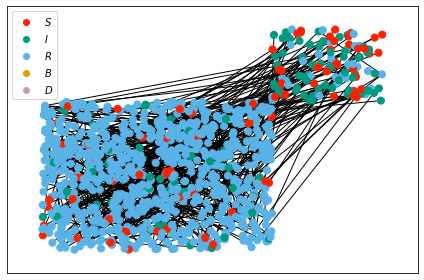

In [31]:
## displays network at peak of infections, with separate clusters 
## and nodes colored by SIR status (weighted edges not shown)

# run simulation
sim = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax = 30, return_full_data=True)

# find time at peak infections to display
argmax = np.argmax(sim.I())
max = np.max(sim.I())
time_argmax = sim.summary()[0][argmax]

# position isolation cluster in top right corner
pos = dict()
for node in G.nodes():
  if G.nodes[node]['isolation_binary'] == {0}: 
    pos[node] = [random.uniform(0,0.75),random.uniform(0,0.75)]
  elif G.nodes[node]['isolation_binary'] == {1}:  
    pos[node] = [random.uniform(0.75,1),random.uniform(0.75,1)]

# display figure
# only 1000 nodes shown to improve visualization
plt.figure(figsize=(50, 5))
sim.display(time=time_argmax, pos=pos, ts_plots=False, node_size=50, nodelist=list(G.nodes)[0:1000:None])
plt.show()

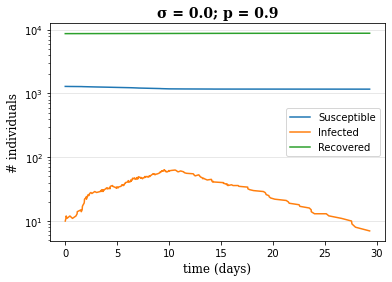

In [27]:
# graph: Figures 3a-d on poster (created by varying p)
## runs simulation and displays time series by SIR status
t, S, I, R, B, D = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax = 30)

fig, ax = plt.subplots()
ax.grid(axis='y', which='major', color='lightgray', linewidth=0.5)
plt.semilogy(t,S,label='Susceptible')
plt.semilogy(t,I,label='Infected')
plt.semilogy(t,R,label='Recovered')
plt.title("σ = " + str(ISO_PROP) + "; p = " + str(PROP_VAX), fontweight="bold", fontname="serif", fontsize=14)
plt.xlabel("time (days)", fontname="serif", fontsize=12)
plt.ylabel("# individuals", fontname="serif", fontsize=12)
plt.legend()
plt.show()

In [15]:
## runs simulation for range of ISO_PROP & PROP_VAX values for results graphs data

# stores all outputs in matrix
# dim: ISO_PROP x PROP_VAX x OUTPUTS OF INTEREST
val_matrix = np.empty((5,7,7))

N = 10000
ISO_PROP_LIST = [0, .05, .1, .15, .2]

i = 0
for ISO_PROP in ISO_PROP_LIST:
  # creates graph (identical to function above)
  G = nx.fast_gnp_random_graph(N, 10./(N-1))
  node_attributes = {}
  for node in G.nodes():
    p = pr.prob(ISO_PROP)
    if p == True : node_attributes[node] = {1}
    else: node_attributes[node] = {0}

  nx.set_node_attributes(G, values=node_attributes, name='isolation_binary')

  # SIR simulation specifications (identical to function above)
  PROP_VAX_LIST = [0.5,0.6,0.7,0.8,0.9,0.95,0.99]
  VAX_EFF = 0.97
  TRANSMISSION_RATE = 0.9
  GAMMA = 1/8
  MU = .012/365
  ETA = .008/365

  j = 0
  for PROP_VAX in PROP_VAX_LIST:
    def rate_function_iso(G, node):
      if node == {1}:
        return 1.0
      elif node == {0}:
        return (1-PROP_VAX) + PROP_VAX*(1-VAX_EFF)

    def rate_function_gen(G, node):
      if node == {0}:
        return PROP_VAX * VAX_EFF
      elif node == {1}:
        return 0.0

    H = nx.DiGraph()
    H.add_edge('B', 'S', rate=MU*rate_function_iso(G=G, node=G.nodes[node]['isolation_binary']))
    H.add_edge('B', 'R', rate=MU*rate_function_gen(G=G, node=G.nodes[node]['isolation_binary']))
    H.add_edge('I', 'R', rate=GAMMA)
    H.add_edge('S', 'D', rate=ETA)
    H.add_edge('I', 'D', rate=ETA)
    H.add_edge('R', 'D', rate=ETA)
    H.add_edge('D', 'B', rate = 1)

    def contact_rate(G, source, target):
      if source == {1} and target == {1}:
        return 2.0
      elif source != target:
        return 0.1
      elif source == {0} and target == {0}:
        return 1.0

    J = nx.DiGraph()
    J.add_edge(('I', 'S'), ('I', 'I'), rate = TRANSMISSION_RATE*
              contact_rate(G=G, source=G.nodes[node]['isolation_binary'], target=G.nodes[node]['isolation_binary']))

    IC = defaultdict(lambda: 'S')
    for node in G.nodes():
      p = pr.prob(PROP_VAX*VAX_EFF)
      if node_attributes[node] == {1}: IC[node] = 'S'
      elif node_attributes[node] == {0} and p == True: IC[node] = 'R'
      elif node_attributes[node] == {0} and p == False: IC[node] = 'S'

    for node in range(10):
      IC[node] = 'I'

    for node in range(9950,10000):
      IC[node] = 'B'

    return_statuses = ('S', 'I', 'R', 'B', 'D')
    
    # calculates number infected by cluster at different times
    sim = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax = 30, return_full_data=True)
    argmax = np.argmax(sim.I())
    max = np.max(sim.I())
    time_argmax = sim.summary()[0][argmax]
    t = sim.summary()[0]
    time_30 = t[len(t)-1]
    i_iso = 0
    i_gen = 0
    i_iso30 = 0
    i_gen30 = 0
    for node in G.nodes():
      # for peak of infections
      if sim.node_status(node,time_argmax) == 'I':
        if G.nodes[node]['isolation_binary'] == {1}:
          i_iso += 1
        if G.nodes[node]['isolation_binary'] == {0}:
          i_gen += 1
      # after 30 days
      if sim.node_status(node,time_30) == 'I':
        if G.nodes[node]['isolation_binary'] == {1}:
          i_iso30 += 1
        if G.nodes[node]['isolation_binary'] == {0}:
          i_gen30 += 1

    total_i = i_iso + i_gen
    total_i30 = i_iso30 + i_gen30

    assert(total_i == max)

    # calculates total number infected over 30 days by cluster
    I = 0
    I_iso = 0
    I_gen = 0
    for node in G.nodes():
      if sim.node_history(node)[1] == ['S','I','R']:
        I += 1
        if G.nodes[node]['isolation_binary'] == {1}:
          I_iso += 1
        if G.nodes[node]['isolation_binary'] == {0}:
          I_gen += 1

    assert(I_iso + I_gen == I)

    # STORED OUTPUTS (can change depending on research question):
    # total infected
    val_matrix[i,j,0] = I
    # number infected at peak
    val_matrix[i,j,1] = max
    # proportion isolated of peak infected
    val_matrix[i,j,2] = i_iso/total_i
    # number infected at t=30
    val_matrix[i,j,3] = total_i30
    # proportion isolated of infected at t=30
    if total_i30 > 0: 
      val_matrix[i,j,4] = i_iso30/total_i30
    else: 
      val_matrix[i,j,4] = 0
    # total infected in general population
    val_matrix[i,j,5] = I_gen
    # number infected in general population at peak   
    val_matrix[i,j,6] = i_gen

    j += 1
  i += 1

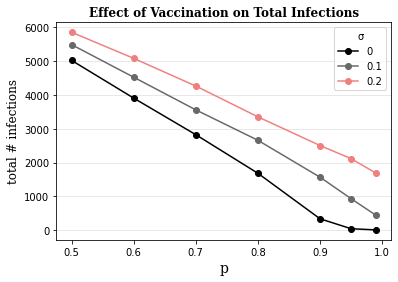

In [13]:
# graph: Figure 4 on poster
fig, ax = plt.subplots()
ax.grid(axis='y', which='major', color='lightgray', linewidth=0.5)

plt.plot(PROP_VAX_LIST, val_matrix[0,:,0], linestyle='-', marker='o', color='black', label=str(ISO_PROP_LIST[0]))
#plt.plot(PROP_VAX_LIST, val_matrix[1,:,0], linestyle='-', marker='o', color='crimson', label=str(ISO_PROP_LIST[1]))
plt.plot(PROP_VAX_LIST, val_matrix[2,:,0], linestyle='-', marker='o', color='dimgray', label=str(ISO_PROP_LIST[2]))
#plt.plot(PROP_VAX_LIST, val_matrix[3,:,0], linestyle='-', marker='o', color='steelblue', label=str(ISO_PROP_LIST[3]))
plt.plot(PROP_VAX_LIST, val_matrix[4,:,0], linestyle='-', marker='o', color='lightcoral', label=str(ISO_PROP_LIST[4]))
plt.title("Effect of Vaccination on Total Infections", fontweight='bold', fontname='serif')
plt.xlabel("p", fontname='serif', fontsize=14)
plt.ylabel("total # infections", fontname='serif', fontsize=12)
plt.legend(title='σ')
plt.show()

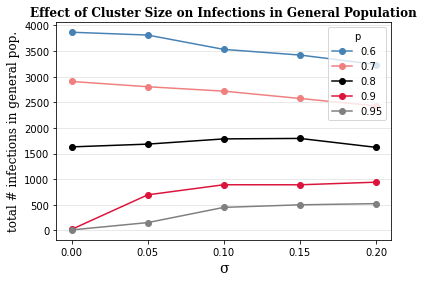

In [43]:
# graph: Figure 5 on poster
fig, ax = plt.subplots()
ax.grid(axis='y', which='major', color='lightgray', linewidth=0.5)

#plt.plot(ISO_PROP_LIST, val_matrix[:,0,5], label=str(PROP_VAX_LIST[0]), color='steelblue', linestyle='-', marker='o')
plt.plot(ISO_PROP_LIST, val_matrix[:,1,5], label=str(PROP_VAX_LIST[1]), color='steelblue', linestyle='-', marker='o')
plt.plot(ISO_PROP_LIST, val_matrix[:,2,5], label=str(PROP_VAX_LIST[2]), color='lightcoral', linestyle='-', marker='o')
plt.plot(ISO_PROP_LIST, val_matrix[:,3,5], label=str(PROP_VAX_LIST[3]), color='black', linestyle='-', marker='o')
plt.plot(ISO_PROP_LIST, val_matrix[:,4,5], label=str(PROP_VAX_LIST[4]), color='crimson', linestyle='-', marker='o')
plt.plot(ISO_PROP_LIST, val_matrix[:,5,5], label=str(PROP_VAX_LIST[5]), color='gray', linestyle='-', marker='o')
#plt.plot(ISO_PROP_LIST, val_matrix[:,6,5], label=str(PROP_VAX_LIST[6]), color='black', linestyle='-', marker='o')
plt.xticks(ticks=ISO_PROP_LIST)
plt.xlabel('σ', fontname='serif', fontsize=14)
plt.ylabel("total # infections in general pop.", fontname='serif', fontsize=12)
plt.legend(title="p", loc='upper right')
plt.title("Effect of Cluster Size on Infections in General Population", fontweight='bold', fontname='serif')
plt.show()

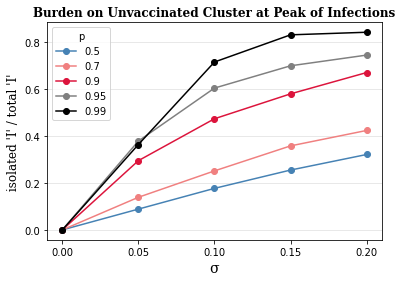

In [22]:
# graph: Figure 6 on poster
fig, ax = plt.subplots()
ax.grid(axis='y', which='major', color='lightgray', linewidth=0.5)

plt.plot(ISO_PROP_LIST, val_matrix[:,0,2], label=str(PROP_VAX_LIST[0]), color='steelblue', linestyle='-', marker='o')
#plt.plot(ISO_PROP_LIST, val_matrix[:,1,2], label=str(PROP_VAX_LIST[1]), color='gray', linestyle='-', marker='o')
plt.plot(ISO_PROP_LIST, val_matrix[:,2,2], label=str(PROP_VAX_LIST[2]), color='lightcoral', linestyle='-', marker='o')
#plt.plot(ISO_PROP_LIST, val_matrix[:,3,2], label=str(PROP_VAX_LIST[3]), color='lightcoral', linestyle='-', marker='o')
plt.plot(ISO_PROP_LIST, val_matrix[:,4,2], label=str(PROP_VAX_LIST[4]), color='crimson', linestyle='-', marker='o')
plt.plot(ISO_PROP_LIST, val_matrix[:,5,2], label=str(PROP_VAX_LIST[5]), color='gray', linestyle='-', marker='o')
plt.plot(ISO_PROP_LIST, val_matrix[:,6,2], label=str(PROP_VAX_LIST[6]), color='black', linestyle='-', marker='o')
plt.xticks(ticks=ISO_PROP_LIST)
plt.xlabel('σ', fontname='serif', fontsize=14)
plt.ylabel("isolated 'I' / total 'I'", fontname='serif', fontsize=12)
plt.legend(title="p")
plt.title("Burden on Unvaccinated Cluster at Peak of Infections", fontweight='bold', fontname='serif')
plt.show()